In [125]:
# Loading

import pandas as pd
df_combined = pd.read_parquet('parquets/house2/df_combined1')

In [108]:
for col in df_combined.columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce')

In [110]:
device_columns = ['kettle', 'rice_cooker', 'washing_machine', 'dish_washer', 'microwave', 'toaster']

# Check unique states for each device
for device in device_columns:
    unique_states = df_combined[device].unique()
    print(f"Device: {device}, Unique States: {unique_states}, Number of States: {len(unique_states)}")

Device: kettle, Unique States: [0 2 1], Number of States: 3
Device: rice_cooker, Unique States: [0 1 2], Number of States: 3
Device: washing_machine, Unique States: [0 1 3 2], Number of States: 4
Device: dish_washer, Unique States: [0 2 1 3], Number of States: 4
Device: microwave, Unique States: [0 1 3 2 4], Number of States: 5
Device: toaster, Unique States: [0 1], Number of States: 2


In [126]:
df_combined.shape

(197777, 12)

<h3><center><b>Random forests</b></center></h3>
<hr>

In [111]:
df_combined.drop('timestamp', axis=1, inplace=True)

In [112]:
X = df_combined[['what_hour', 'what_day', 'is_weekend', 'aggregate', 'agg_clustered']]

Y_columns = df_combined.columns.difference(X.columns)
Y = df_combined[Y_columns]

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# for grid search
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

base_rf = RandomForestClassifier(random_state=42)
model = MultiOutputClassifier(base_rf, n_jobs=-1)

# GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

best_params = grid_search.best_params_

best_rf = RandomForestClassifier(
    n_estimators=best_params['estimator__n_estimators'],
    max_depth=best_params['estimator__max_depth'],
    min_samples_split=best_params['estimator__min_samples_split'],
    min_samples_leaf=best_params['estimator__min_samples_leaf'],
    random_state=42
)

best_model = MultiOutputClassifier(best_rf, n_jobs=-1)

# The best_model now looks like this:
print(best_model)


c:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters found:  {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Best cross-validation score: nan
MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                       random_state=42),
                      n_jobs=-1)


In [114]:
# Best parameters found

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

best_rf = RandomForestClassifier(n_estimators= 50, min_samples_leaf= 1, min_samples_split= 2, max_depth= None, random_state=42)

model = MultiOutputClassifier(best_rf, n_jobs=1)

In [115]:
model.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                       random_state=42),
                      n_jobs=1)

In [116]:
y_pred = model.predict(X_test)

In [117]:
import numpy as np
import pandas as pd
from sklearn.metrics import hamming_loss

def exact_match_accuracy(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    exact_matches = np.all(true == pred, axis=1)
    accuracy = np.mean(exact_matches)
    return accuracy

y_pred_df = pd.DataFrame(y_pred, columns=Y_test.columns, index=Y_test.index)

Y_test_np = Y_test.to_numpy().astype(int)
y_pred_np = y_pred_df.to_numpy().astype(int)

# accuracy
exact_accuracy = exact_match_accuracy(Y_test_np, y_pred_np)
print(f"Exact Match Accuracy: {exact_accuracy:.2%}")

mismatches = Y_test_np != y_pred_np
hamming_losses = mismatches.mean(axis=0)
hamming_accuracies = 1 - hamming_losses

# Hamming accuracy for each label
for i, accuracy in enumerate(hamming_accuracies):
    print(f"Hamming Accuracy for Label {i+1} ({Y_test.columns[i]}): {accuracy:.2%}")

# overall Hamming accuracy
overall_hamming_accuracy = 1 - np.mean(hamming_losses)
print(f"Overall Hamming Accuracy: {overall_hamming_accuracy:.2%}")


Exact Match Accuracy: 99.75%
Hamming Accuracy for Label 1 (dish_washer): 99.89%
Hamming Accuracy for Label 2 (kettle): 99.99%
Hamming Accuracy for Label 3 (microwave): 99.90%
Hamming Accuracy for Label 4 (rice_cooker): 99.98%
Hamming Accuracy for Label 5 (toaster): 99.99%
Hamming Accuracy for Label 6 (washing_machine): 99.88%
Overall Hamming Accuracy: 99.94%


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report for each target:")
for i, column in enumerate(Y_test.columns):
    print(f"\nClassification Report for {column}:")
    print(classification_report(Y_test.iloc[:, i], y_pred[:, i]))


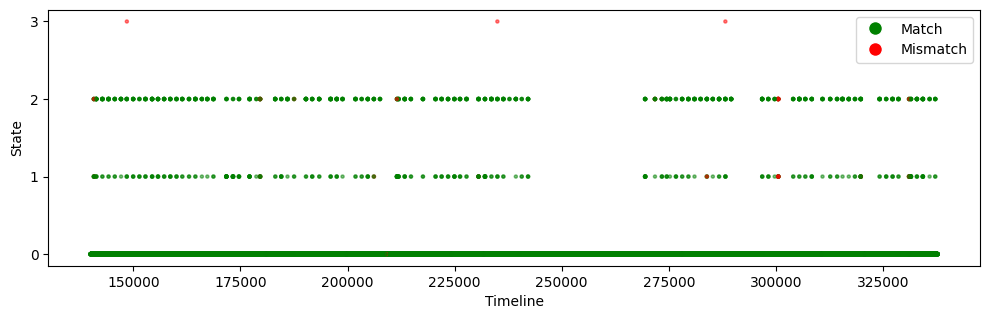

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

#  example
device = 0
n_samples =  49345

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
y_pred = pd.DataFrame(y_pred)

colors = np.array(['green' if int(a) == int(b) else 'red' for a, b in zip(y_pred.iloc[:n_samples, device], Y_test.iloc[:n_samples, device])])

x_indices = Y_test.index[:n_samples]

scatter = plt.scatter(x_indices, Y_test.iloc[:n_samples, device].astype(int),
                      c=colors, alpha=0.5, s=5)

plt.yticks(np.arange(min(Y_test.iloc[:n_samples, device].astype(int)), max(Y_test.iloc[:n_samples, device].astype(int)) + 1))

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Match',
                          markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Mismatch',
                          markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

# plt.title('Actual vs. Predicted States')
plt.ylabel('State')
plt.xlabel('Timeline')

plt.tight_layout()
plt.show()

In [119]:
# Extract feature importance

for i, estimator in enumerate(model.estimators_):
    print(f"Feature importances for target {Y_train.columns[i]}:")
    importances = estimator.feature_importances_
    features = X_train.columns
    indices = importances.argsort()[::-1]

    for f in range(X_train.shape[1]):
        print(f"{features[indices[f]]}: {importances[indices[f]]}")
    print("\n")


Feature importances for target dish_washer:
aggregate: 0.46201934782455756
agg_clustered: 0.4335409236314448
what_hour: 0.09400124253363601
what_day: 0.008413902567494705
is_weekend: 0.0020245834428670294


Feature importances for target kettle:
agg_clustered: 0.6045375845518667
aggregate: 0.3814431764642215
what_hour: 0.009059267845084231
what_day: 0.0036536048721793387
is_weekend: 0.001306366266648314


Feature importances for target microwave:
aggregate: 0.5114712303971346
agg_clustered: 0.3293876837648055
what_hour: 0.12474880775289093
what_day: 0.01946359133946606
is_weekend: 0.014928686745702892


Feature importances for target rice_cooker:
aggregate: 0.5224294424617323
agg_clustered: 0.2706002315689433
what_hour: 0.18564837151584557
what_day: 0.01708460782553921
is_weekend: 0.004237346627939596


Feature importances for target toaster:
aggregate: 0.8850108969382318
agg_clustered: 0.04927100313650297
what_hour: 0.0488315670729051
what_day: 0.01306106536406599
is_weekend: 0.003825